In [1]:
import sys
# !{sys.executable} -m pip install seaborn

In [2]:
import csv
import math
import random
import operator
import time
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Diabetes

### Reading and Parsing the Data

In [154]:
diabetes_df = pd.read_csv("./data/diabetes/diabetes.csv")

diabetes_df[:5]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Let's check if the distribution of 0/1 is even in the dataset

#### If not, we will chop some values off

In [4]:
ct = diabetes_df['Outcome'].value_counts().reset_index()
ct.columns = ['Outcome', 'Count']
print(ct)

# Too many 0's, have to remove some

count_0 = 0
for index, row in diabetes_df.iterrows():
    if row['Outcome'] == 0:
        count_0 += 1
    if row['Outcome'] == 0 and count_0 > 268:
        diabetes_df = diabetes_df.drop(index)

ct1 = diabetes_df['Outcome'].value_counts().reset_index()
ct1.columns = ['Outcome', 'Count']
print(ct1)

   Outcome  Count
0        0    500
1        1    268
   Outcome  Count
0        1    268
1        0    268


### Histograms

#### Plotting some histograms to see how each feature in the dataset affects diabetes

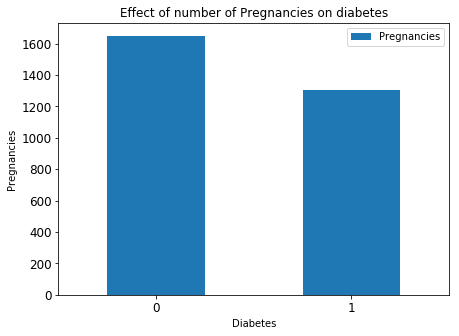

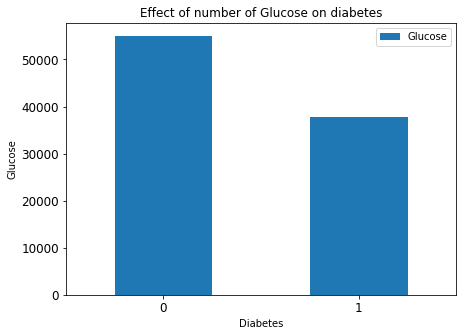

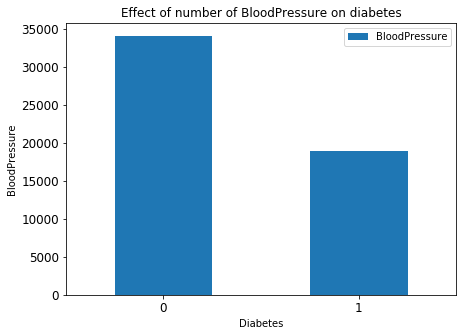

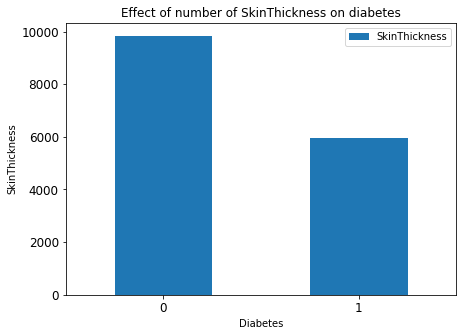

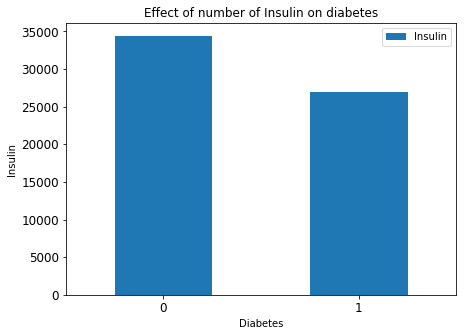

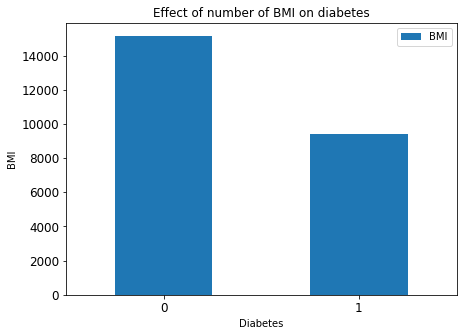

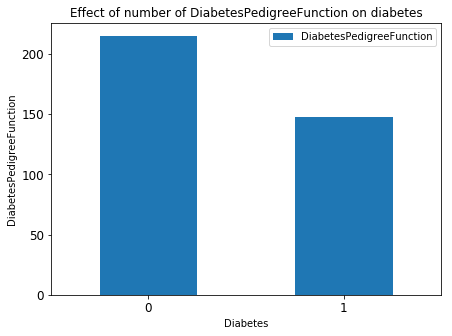

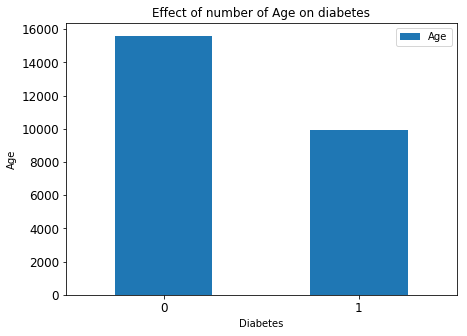

In [158]:
def build_df_for_histogram(df, column):
    df_0 = 0
    df_1 = 0
    columns = ['Outcome', column]
    for index, row in df.iterrows():
        if row['Outcome'] == 0:
            df_0 = df_0 + row[column].astype(float)
        elif row['Outcome'] == 1:
            df_1 = df_1 + row[column].astype(float)
    dct = {0: df_0, 1: df_1}
    df_hist = pd.DataFrame(list(dct.items()), columns=['Diabetes', column])
    return df_hist


def plot_hist_for_column(column):
    df_hist = build_df_for_histogram(diabetes_df, column)
    hist = df_hist[[column]].plot(kind='bar', title ="Effect of number of " + str(column) + " on diabetes", figsize=(7, 5), fontsize=12)
    hist.set_xlabel("Diabetes")
    hist.set_ylabel(column)
    plt.xticks(rotation=0)
    plt.show()


plot_hist_for_column('Pregnancies')
plot_hist_for_column('Glucose')
plot_hist_for_column('BloodPressure')
plot_hist_for_column('SkinThickness')
plot_hist_for_column('Insulin')
plot_hist_for_column('BMI')
plot_hist_for_column('DiabetesPedigreeFunction')
plot_hist_for_column('Age')


### Scatter Plots

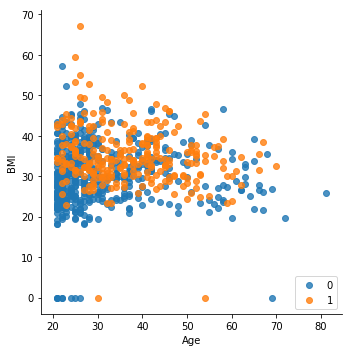

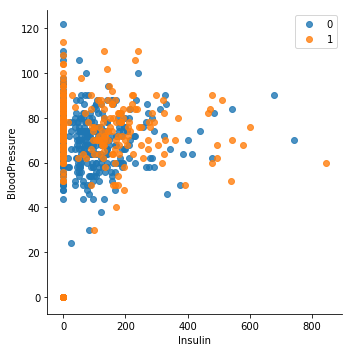

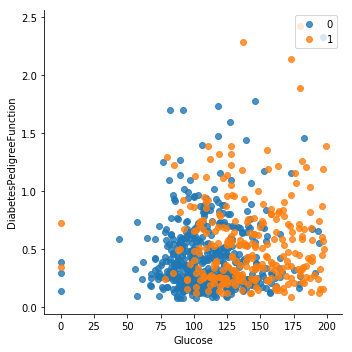

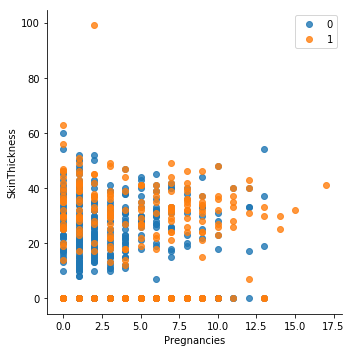

In [160]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="Age", y="BMI", data=diabetes_df, fit_reg=False, hue='Outcome', legend=False)
plt.legend(loc='lower right')

sns.lmplot( x="Insulin", y="BloodPressure", data=diabetes_df, fit_reg=False, hue='Outcome', legend=False)
plt.legend(loc='upper right')

sns.lmplot( x="Glucose", y="DiabetesPedigreeFunction", data=diabetes_df, fit_reg=False, hue='Outcome', legend=False)
plt.legend(loc='upper right')

sns.lmplot( x="Pregnancies", y="SkinThickness", data=diabetes_df, fit_reg=False, hue='Outcome', legend=False)
plt.legend(loc='upper right')
 
# sns.plt.show()

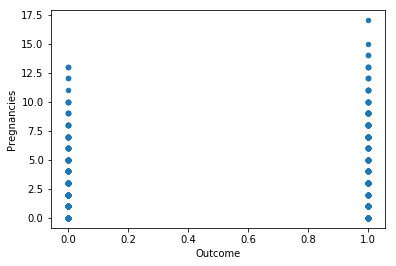

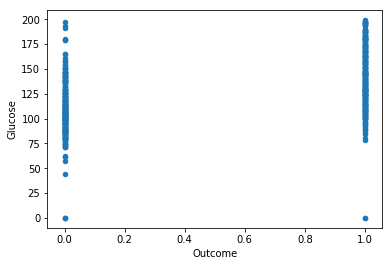

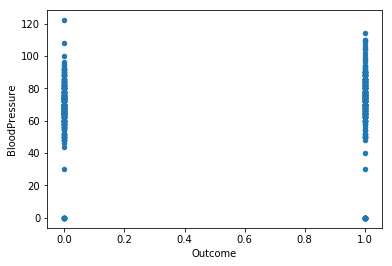

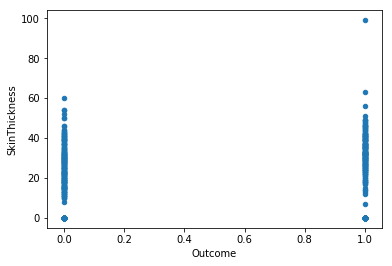

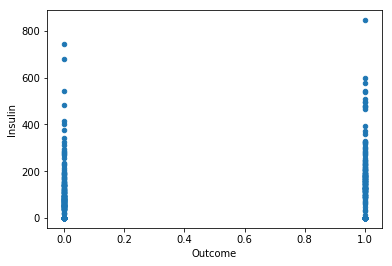

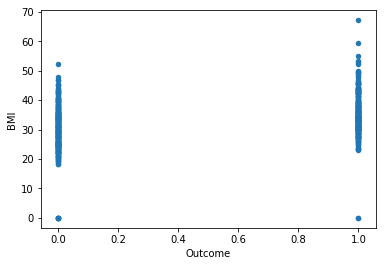

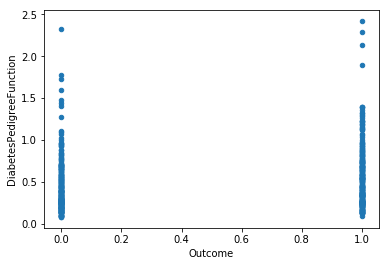

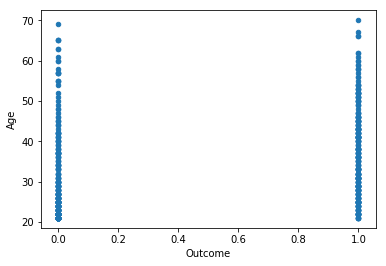

In [7]:
diabetes_df.plot.scatter('Outcome', 'Pregnancies')
diabetes_df.plot.scatter('Outcome', 'Glucose')
diabetes_df.plot.scatter('Outcome', 'BloodPressure')
diabetes_df.plot.scatter('Outcome', 'SkinThickness')
diabetes_df.plot.scatter('Outcome', 'Insulin')
diabetes_df.plot.scatter('Outcome', 'BMI')
diabetes_df.plot.scatter('Outcome', 'DiabetesPedigreeFunction')
diabetes_df.plot.scatter('Outcome', 'Age')

Some observations from the histograms and the scatter plots:

- Generally, we can see that the larger amount of pregnancies per lifetime correlates to the presence of diabates, but it's not a very obvious correlation so we will leave it out
- Glucose levels also correlate to a higher likelihood of having diabetes (which is pretty intuitive)
- There isn't much correlation between blood pressure and diabetes
- Although thicker skin is more likely to correlate to the presence of diabetes, that correlation is not very strong
- Higher levels of insulun seem to have a strong correlation to diabetes
- Higher BMI is more prevalent in those with diabetes
- Higher diabetes pedigree function seems to correlate with higher likelihood of diabetes, but it's not very obvious
- Lower age correlates to lower likelihood of diabetes, but it is not very strong

Therefore the following will be our selected features:

- BMI
- Glucose
- Insulin


In [82]:
features = ['BMI', 'Glucose', 'Insulin']
label = 'Outcome'
all_columns = features + [label]
diabetes_df = diabetes_df[all_columns]
diabetes_df

,BMI,Glucose,Insulin,Outcome
0,0.500745,0.743719,0.000000,1
1,0.396423,0.427136,0.000000,0
2,0.347243,0.919598,0.000000,1
3,0.418778,0.447236,0.111111,0
4,0.642325,0.688442,0.198582,1
...,...,...,...,...
755,0.543964,0.643216,0.130024,1
757,0.540984,0.618090,0.000000,1
759,0.529061,0.954774,0.000000,1
761,0.655738,0.854271,0.000000,1


## Distance Measures

https://pdfs.semanticscholar.org/a630/316f9c98839098747007753a9bb6d05f752e.pdf

https://lyfat.wordpress.com/2012/05/22/euclidean-vs-chebyshev-vs-manhattan-distance/

### Euclidean Distance

In [51]:
def euclidean_dist(pt1, pt2):
    diff = pt1 - pt2
    distances = np.sqrt(np.sum(diff**2, axis=1))
    return distances

### Manhattan Distance

In [52]:
def manhattan_dist(pt1, pt2):
    diff = pt1 - pt2
    return np.sum(np.abs(diff), axis=1)

### Chebyshev Distance

In [53]:
def chebyshev_dist(pt1, pt2):
    diff = pt1 - pt2
    return np.max(np.abs(diff), axis=1)

## Pre-processing the Data

### Shuffle and Split the Data

In [12]:
def split_data(df, split=0.8, seed=None):
    shuf_df = df.sample(frac=1, random_state=seed)  #shuffle rows in the df
    n = math.ceil(split * shuf_df.shape[0])
    train_df = shuf_df.head(n)
    test_df = shuf_df.tail(len(shuf_df) - n)
    return train_df, test_df

### Rescaling -- Min-Max

This is just for the Pima dataset

In [13]:
# pt_norm = (pt - pt_min)/(pt_max - pt_min)
def main_max_rescaling(df):
    for col in df:
        if col == 'Outcome':
            continue
        else:
            pt_min = df[col].min()
            pt_max = df[col].max()
            df[col] = (df[col] - pt_min) / (pt_max - pt_min)

In [83]:
main_max_rescaling(diabetes_df)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [85]:
diabetes_df

,BMI,Glucose,Insulin,Outcome
0,0.500745,0.743719,0.000000,1
1,0.396423,0.427136,0.000000,0
2,0.347243,0.919598,0.000000,1
3,0.418778,0.447236,0.111111,0
4,0.642325,0.688442,0.198582,1
...,...,...,...,...
755,0.543964,0.643216,0.130024,1
757,0.540984,0.618090,0.000000,1
759,0.529061,0.954774,0.000000,1
761,0.655738,0.854271,0.000000,1


## The Main Algorithm

### KNN

In [18]:
def compute_knn(k, train_set, test, dist_method):
    distances = dist_method(train_set, test)
    if k == 1:
        return np.argmin(distances, axis = 0)
    else:
        return np.argsort(distances, axis = 0)[:k]

def knn(k, train, test, features, label, dist_method):
    train_vector = train[features].to_numpy()
    test_vector = test[features].to_numpy()
    train_labels = train[[label]].to_numpy().reshape(len(train))
    labels = []
    for item in test_vector:
        near = compute_knn(k, train_vector, item, dist_method)
        if k == 1:
            l = train_labels[near]
        else:
            l = np.argmax(np.bincount(train_labels[near])) # select max label
        labels.append(l)
    return labels
    

In [19]:
train, test = split_data(diabetes_df, seed=123)

train_vector = train[features].to_numpy()
test_vector = test[features].to_numpy()

k = 3
near = compute_knn(k, train_vector, test_vector[1], euclidean_dist) 

In [20]:
near

array([252, 110, 242])

## Performance Measures

### Accuracy

In [177]:
def calc_accuracy(test, label, results):
    test_label = test[[label]].to_numpy()
    pos = 0
    lt = len(test)
    for pt in range(lt):
        if test_label[pt] == results[pt]:
            pos += 1
    return (pos/float(lt)) * 100.0

### Pima -- FP, FN, TP, TN

In [109]:
def pima_perf_table(test, results):
    fp = 0 
    fn = 0
    tp = 0
    tn = 0
    lt = len(test)
    test = test.values.tolist()
    for pt in range(lt):
        if results[pt] == 0 and test[pt][3] == 0:
            tn += 1
        if results[pt] == 1 and test[pt][3] == 1:
            tp += 1
        if results[pt] == 0 and test[pt][3] == 1:
            fn += 1
        if results[pt] == 1 and test[pt][3] == 0:
            fp += 1
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    print("Precision = " + str(precision) + ", Recall = " + str(recall))
    res = [[tn, fp], [fn, tp]] 
    perf_df = pd.DataFrame(res, columns = ['0', '1'])
    return perf_df

### MNIST -- Confusion Matrix

In [189]:
def mnist_conf_matrix(test, results):
    test = test.values.tolist()
    conf_mtr = {}
    cols = []
    for i in range(10):
        cols.append(i)
        conf_mtr[i] = []
        for j in range(10):
            conf_mtr[i].append(0)
    for num in range(len(test)):
        conf_mtr[results[num]][test[num][0]] += 1
    conf_df = pd.DataFrame.from_dict(conf_mtr, orient='index', columns = cols).transpose()
    return conf_df

### Running on the Diabetes Dataset

#### Using Euclidean Distance

In [86]:
%%time

train_df_d, test_df_d = split_data(diabetes_df, seed=1234)
k = 3

start_pima_e = time.time()

results_e = knn(k, train_df_d, test_df_d, features, label, euclidean_dist)
acc_e = calc_accuracy(test_df_d, label, results_e)

total_time = time.time() - start_pima_e

print('Accuracy (Euclidean Distance): ' + str(acc_e) + '%')
print("Performing KNN on the Pima dataset using Euclidean Distance took " + str(total_time))

Accuracy (Euclidean Distance): 70.09345794392523%
Performing KNN on the Pima dataset using Euclidean Distance took 0.05139517784118652
CPU times: user 19.1 ms, sys: 23 ms, total: 42.1 ms
Wall time: 90.9 ms


In [111]:
pima_eucl_table = pima_perf_table(test_df_d, results_e)
pima_eucl_table

Precision = 0.6451612903225806, Recall = 0.8


,0,1
0,35,22
1,10,40


#### Using Manhattan Distance

In [119]:
%%time

start_pima_m = time.time()

results_m = knn(k, train_df_d, test_df_d, features, label, manhattan_dist)
acc_m = calc_accuracy(test_df_d, label, results_m)

total_time = time.time() - start_pima_m
print('Accuracy (Manhattan Distance): ' + str(acc_m) + '%')
print("Performing KNN on the Pima dataset using Manhattan Distance took " + str(total_time))

Accuracy (Manhattan Distance): 70.09345794392523%
Performing KNN on the Pima dataset using Manhattan Distance took 0.020367860794067383
CPU times: user 12 ms, sys: 6.32 ms, total: 18.4 ms
Wall time: 20.5 ms


In [120]:
pima_manh_table = pima_perf_table(test_df_d, results_m)
pima_manh_table

Precision = 0.6451612903225806, Recall = 0.8


,0,1
0,35,22
1,10,40


#### Using Chebyshev Distance

In [116]:
%%time

start_pima_c = time.time()

results_c = knn(k, train_df_d, test_df_d, features, label, chebyshev_dist)
acc_c = calc_accuracy(test_df_d, label, results_c)

end_pima_c = time.time() - start_pima_c
print('Accuracy (Chebyshev Distance): ' + str(acc_c) + '%')
print("Performing KNN on the Pima dataset using Chebyshev Distance took " + str(end_pima_c))

Accuracy (Chebyshev Distance): 73.83177570093457%
Performing KNN on the Pima dataset using Chebyshev Distance took 0.018863916397094727
CPU times: user 11.2 ms, sys: 3.04 ms, total: 14.3 ms
Wall time: 19 ms


In [117]:
pima_cheb_table = pima_perf_table(test_df_d, results_c)
pima_cheb_table

Precision = 0.6833333333333333, Recall = 0.82


,0,1
0,38,19
1,9,41


# MNIST

### Reading and Parsing the Data

In [54]:
mnist_train_df = pd.read_csv("./data/mnist/train.csv")
mnist_test_df = pd.read_csv("./data/mnist/test.csv")

In [55]:
mnist_test = mnist_test_df.values.tolist()
mnist_train = mnist_train_df.values.tolist()

In [56]:
mnist_train_df[:5]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
mnist_train_df.dtypes

label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object

In [58]:
len(mnist_train)

42000

In [66]:
train = mnist_train_df[:33600]
test = mnist_train_df[33600:]

In [67]:
# create features list column value min != max
# n = 100
# train = mnist_train_df[mnist_train_df["label"] == 0].head(n)
# test = mnist_train_df[mnist_train_df["label"] == 0].tail(n)
# for i in range(1, 10):
#     train = train.append(mnist_train_df[mnist_train_df["label"] == i].head(n))
#     test = test.append(mnist_train_df[mnist_train_df["label"] == i].tail(n))

## Varying k values

### Euclidean Distance

#### k = 1

In [143]:
%%time
start_mnist = time.time()

k = 1
label = 'label'
features = []
for i in range(784):
    features.append("pixel%d" % i)

results_m_1_e = knn(k, train, test, features, label, euclidean_dist)
acc_m_1_e = calc_accuracy(test, label, results_m_1_e)

total_time = time.time() - start_mnist

Accuracy for k=1 (Euclidean Distance): 70.09345794392523%
Performing KNN on the MNIST dataset with k=1 (Euclidean Distance) took 3811.692995071411
CPU times: user 25min 12s, sys: 27min 44s, total: 52min 56s
Wall time: 1h 3min 31s


In [195]:
print('Accuracy for k=1 (Euclidean Distance): ' + repr(acc_m_1_e) + '%')
print("Performing KNN on the MNIST dataset with k=1 (Euclidean Distance) took " + str(total_time))

Accuracy for k=1 (Euclidean Distance): 96.73809523809524%
Performing KNN on the MNIST dataset with k=1 (Euclidean Distance) took 3811.692995071411


In [191]:
cm_e_1 = mnist_conf_matrix(test, results_m_1_e)
cm_e_1

,0,1,2,3,4,5,6,7,8,9
0,846,0,0,0,0,1,5,0,0,0
1,0,943,1,1,1,0,1,3,0,0
2,8,2,768,3,1,2,1,13,2,1
3,1,4,6,846,0,10,0,3,9,3
4,0,6,0,0,779,0,4,1,0,21
5,1,2,0,11,1,720,7,0,1,4
6,4,3,0,0,1,4,819,0,0,0
7,0,8,3,0,2,0,0,864,0,7
8,1,16,2,10,3,7,3,2,747,11
9,6,2,1,4,14,2,0,15,2,794


In [207]:
tl = test.values.tolist()
count_7 = 0
for r in range(len(tl)):
    if tl[r][0] == 7:
        count_7 += 1
print(count_7)

884


In [209]:
864/count_7 * 100

97.73755656108597

In [210]:
864/count_7 * 100

97.73755656108597

In [211]:
861/count_7 * 100

97.39819004524887

In [212]:
858/count_7 * 100

97.05882352941177

In [215]:
841/count_7 * 100

95.13574660633483

#### k = 3

In [74]:
%%time
start_mnist = time.time()

k = 3
label = 'label'
features = []
for i in range(784):
    features.append("pixel%d" % i)

results_m_3_e = knn(k, train, test, features, label, euclidean_dist)
acc_m_3_e = calc_accuracy(test, label, results_m_3_e)

total_time = time.time() - start_mnist
print('Accuracy for k=3 (Euclidean Distance): ' + repr(acc_m_3_e) + '%')
print("Performing KNN on the MNIST dataset with k=3 (Euclidean Distance) took " + str(total_time))

Accuracy for k=3 (Euclidean Distance): 96.95238095238096%
Performing KNN on the MNIST dataset with k=3 (Euclidean Distance) took 3672.9269700050354
CPU times: user 25min 27s, sys: 27min 11s, total: 52min 38s
Wall time: 1h 1min 12s


In [192]:
cm_e_3 = mnist_conf_matrix(test, results_m_3_e)
cm_e_3

,0,1,2,3,4,5,6,7,8,9
0,848,1,0,0,0,1,2,0,0,0
1,0,947,1,1,1,0,0,0,0,0
2,8,7,769,3,0,2,0,9,2,1
3,0,3,6,857,0,6,0,3,4,3
4,0,8,0,0,781,0,5,0,0,17
5,3,0,0,16,0,715,7,0,2,4
6,5,2,0,0,0,1,823,0,0,0
7,0,9,3,0,1,0,0,864,0,7
8,3,19,5,12,5,10,1,2,738,7
9,6,2,2,8,7,2,0,11,0,802


#### k = 5

In [75]:
%%time
start_mnist = time.time()

k = 5
label = 'label'
features = []
for i in range(784):
    features.append("pixel%d" % i)

results_m_5_e = knn(k, train, test, features, label, euclidean_dist)
acc_m_5_e = calc_accuracy(test, label, results_m_5_e)

total_time = time.time() - start_mnist
print('Accuracy for k=5 (Euclidean Distance): ' + repr(acc_m_5_e) + '%')
print("Performing KNN on the MNIST dataset with k=5 (Euclidean Distance) took " + str(total_time))

Accuracy for k=5 (Euclidean Distance): 96.9047619047619%
Performing KNN on the MNIST dataset with k=5 (Euclidean Distance) took 2840.437040090561
CPU times: user 22min 53s, sys: 23min 7s, total: 46min 1s
Wall time: 47min 20s


In [193]:
cm_e_5 = mnist_conf_matrix(test, results_m_5_e)
cm_e_5

,0,1,2,3,4,5,6,7,8,9
0,849,0,0,0,0,1,2,0,0,0
1,0,949,1,0,0,0,0,0,0,0
2,9,7,767,2,0,3,0,12,0,1
3,2,3,8,854,0,6,0,2,3,4
4,0,8,0,0,784,0,3,0,1,15
5,2,1,0,14,0,715,9,0,2,4
6,3,2,0,0,1,1,824,0,0,0
7,0,10,3,0,1,0,0,861,0,9
8,3,20,2,8,4,12,1,1,745,6
9,6,4,2,5,8,2,0,19,2,792


#### k = 15

In [76]:
%%time
start_mnist = time.time()

k = 15
label = 'label'
features = []
for i in range(784):
    features.append("pixel%d" % i)

results_m_15_e = knn(k, train, test, features, label, euclidean_dist)
acc_m_15_e = calc_accuracy(test, label, results_m_15_e)

total_time = time.time() - start_mnist
print('Accuracy for k=15 (Euclidean Distance): ' + repr(acc_m_15_e) + '%')
print("Performing KNN on the MNIST dataset with k=15 (Euclidean Distance) took " + str(total_time))

Accuracy for k=15 (Euclidean Distance): 96.03571428571429%
Performing KNN on the MNIST dataset with k=15 (Euclidean Distance) took 3010.0648601055145
CPU times: user 23min 36s, sys: 24min 3s, total: 47min 40s
Wall time: 50min 10s


In [194]:
cm_e_15 = mnist_conf_matrix(test, results_m_15_e)
cm_e_15

,0,1,2,3,4,5,6,7,8,9
0,843,1,0,0,0,2,6,0,0,0
1,0,947,1,0,1,0,1,0,0,0
2,15,17,742,2,0,4,2,15,1,3
3,2,9,3,847,0,9,0,4,4,4
4,0,10,0,0,772,0,3,0,1,25
5,3,6,0,10,3,709,12,0,1,3
6,4,2,0,0,1,0,824,0,0,0
7,0,13,3,0,0,0,0,858,0,10
8,3,20,0,11,6,9,7,1,736,9
9,7,6,2,9,6,1,0,20,0,789


#### k = 91

In [77]:
%%time
start_mnist = time.time()

k = 91
label = 'label'
features = []
for i in range(784):
    features.append("pixel%d" % i)

results_m_91_e = knn(k, train, test, features, label, euclidean_dist)
acc_m_91_e = calc_accuracy(test, label, results_m_91_e)

total_time = time.time() - start_mnist
print('Accuracy for k=91 (Euclidean Distance): ' + repr(acc_m_91_e) + '%')
print("Performing KNN on the MNIST dataset with k=91 (Euclidean Distance) took " + str(total_time))

Accuracy for k=15 (Euclidean Distance): 93.44047619047619%
Performing KNN on the MNIST dataset with k=15 (Euclidean Distance) took 3311.2230122089386
CPU times: user 24min 3s, sys: 25min 21s, total: 49min 25s
Wall time: 55min 11s


In [214]:
cm_e_91 = mnist_conf_matrix(test, results_m_91_e)
cm_e_91

,0,1,2,3,4,5,6,7,8,9
0,835,2,1,0,0,2,11,0,0,1
1,0,948,1,0,1,0,0,0,0,0
2,19,35,702,5,1,3,4,20,6,6
3,1,15,6,816,1,17,3,8,4,11
4,0,22,0,0,738,0,6,0,1,44
5,3,13,0,14,4,683,16,0,1,13
6,7,9,0,0,2,0,813,0,0,0
7,0,26,3,0,0,0,0,841,0,14
8,5,42,0,19,6,14,7,2,690,17
9,7,10,1,11,5,0,0,23,0,783


### Manhattan Distance

#### k = 1

In [45]:
%%time
start_mnist_1 = time.time()

k = 1
label = 'label'

results_m_1 = knn(k, train, test, features, label, manhattan_dist)
acc_m_1 = calc_accuracy(test, label, results_m_1)

total_time_1 = time.time() - start_mnist_1
print('Accuracy with k=1: ' + repr(acc_m_1) + '%')
print("Performing KNN on the MNIST dataset with k=1 took " + str(total_time_1))

Accuracy with k=1: 11.30952380952381%
Performing KNN on the MNIST dataset with k=1 took 2470.67232298851
CPU times: user 19min 27s, sys: 21min 6s, total: 40min 33s
Wall time: 41min 10s


#### k = 3

In [46]:
%%time
start_mnist_3 = time.time()

k = 3
label = 'label'

results_m_3 = knn(k, train, test, features, label, manhattan_dist)
acc_m_3 = calc_accuracy(test, label, results_m_3)

total_time_3 = time.time() - start_mnist_3
print('Accuracy with k=3: ' + repr(acc_m_3) + '%')
print("Performing KNN on the MNIST dataset with k=3 took " + str(total_time_3))

Accuracy with k=3: 11.30952380952381%
Performing KNN on the MNIST dataset with k=3 took 2410.6521821022034
CPU times: user 19min 11s, sys: 20min 36s, total: 39min 47s
Wall time: 40min 10s


#### k = 5

In [47]:
%%time
start_mnist_5 = time.time()

k = 5
label = 'label'

results_m_5 = knn(k, train, test, features, label, manhattan_dist)
acc_m_5 = calc_accuracy(test, label, results_m_5)

total_time_5 = time.time() - start_mnist_5
print('Accuracy with k=5: ' + repr(acc_m_5) + '%')
print("Performing KNN on the MNIST dataset with k=5 took " + str(total_time_5))

Accuracy with k=5: 11.30952380952381%
Performing KNN on the MNIST dataset with k=5 took 2400.5089428424835
CPU times: user 19min 5s, sys: 20min 35s, total: 39min 41s
Wall time: 40min


#### k = 15

In [48]:
%%time
start_mnist_15 = time.time()

k = 15
label = 'label'

results_m_15 = knn(k, train, test, features, label, manhattan_dist)
acc_m_15 = calc_accuracy(test, label, results_m_15)

total_time_15 = time.time() - start_mnist_15
print('Accuracy with k=15: ' + repr(acc_m_15) + '%')
print("Performing KNN on the MNIST dataset with k=15 took " + str(total_time_15))

Accuracy with k=15: 11.30952380952381%
Performing KNN on the MNIST dataset with k=15 took 2405.2189650535583
CPU times: user 19min 6s, sys: 20min 36s, total: 39min 43s
Wall time: 40min 5s


In [49]:
%%time
start_mnist_91 = time.time()

k = 91
label = 'label'

results_m_91 = knn(k, train, test, features, label, manhattan_dist)
acc_m_91 = calc_accuracy(test, label, results_m_91)

total_time_91 = time.time() - start_mnist_91
print('Accuracy with k=91: ' + repr(acc_m_91) + '%')
print("Performing KNN on the MNIST dataset with k=91 took " + str(total_time_91))

Accuracy with k=15: 11.30952380952381%
Performing KNN on the MNIST dataset with k=15 took 2403.3015480041504
CPU times: user 19min 6s, sys: 20min 35s, total: 39min 42s
Wall time: 40min 3s


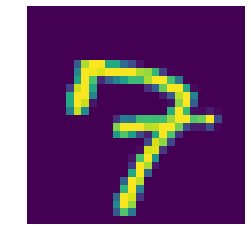

In [152]:
num = mnist_test_df.iloc[5].to_numpy()
img = num.reshape((28, 28))
plt.imshow(img)
plt.axis("off")
plt.imsave("./images/seven.png", img)